# What Makes a Song Go TikTok Viral?

As an avid TikTok user, I noticed that there are certain songs that go viral for a period of time. These songs could be related to a current trend on the app, a popular artist's recent release, or reasons unknown which is why I would like to collect and analyze what makes a song go viral on TikTok.

 In order to find out what makes a TikTok song viral, I first have to collect data on the TikTok's top trending songs. BillBoard puts out a chart of the top 50 TikTok songs for every week. Using the Wayback Machine, I am going to collect all of the data available on their website. Wayback has every weeks' chart from September 14th 2023, so I will be collecting 13 weeks of data to analyze.

 To understand how these songs became TikTok trends, I am going to analyze them with the Spotify API. The API has an endpoint called audio features, which allows the user to make a request for a song and see various elements of the song such as acousticness, tempo, danceability, etc. I will be analyzing the features of these songs to find similarities and potentially create a formula for what makes a song go viral on TikTok.

Imports for analysis

In [61]:
import requests
import json
from time import sleep
from bs4 import BeautifulSoup
from urllib.parse import unquote, quote
from datetime import datetime
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import time

# Method 1 - Using Wayback Machine to Collect TikTok Songs

In order to get all of the historical data for the TikTok Billboard charts, I am going to scrape all of the charts that the Wayback Machine Internet Archive has available. 

I made a list of dates for each week's snapshot of the charts that are available.

In [3]:
dates = ["20230914","20230922","20230929","20231003","20231009","20231016","20231024","20231030","20231107","20231114","20231122","20231128","20231204"]

This dictionary will hold all of the songs, artists, and their rankings.

In [4]:
data = {
    "artist":[],
    "song":[],
    "rank":[],
    "date":[]
}

In order to get all of the data from each chart, I looped through each and requested the page for each chart. I soupified each request and searched for the chart. In each chart I added the informatiom about each song to the dictionary.

Some charts had elements located in different places so I had to change the search format.

In [5]:
for date in dates:
    wb_url = 'http://archive.org/wayback/available?url=billboard.com/charts/tiktok-billboard-top-50/&timestamp='+date
    wb_response = requests.get(wb_url)
    wb_response_json = wb_response.json()
    recent_bb_wb_url = wb_response_json['archived_snapshots']['closest']['url']
    recent_bb_wb_response = requests.get(recent_bb_wb_url)
    recent_bb_wb_raw = recent_bb_wb_response.text
    recent_bb_wb_soup = BeautifulSoup(recent_bb_wb_raw)
    table = recent_bb_wb_soup.find_all('div',{"class":"o-chart-results-list-row-container"})
    for row in table:
        if(date in ["20230914"]):
            artist = row.find_all("span")[3].text.strip()
            data["artist"].append(artist)
        elif(date in dates[1:]):
            if(row.find_all("span")[1].text.strip() in ["NEW","RE-\nENTRY","HUS"]):
                artist = row.find_all("span")[3].text.strip()
                data["artist"].append(artist)
            else:
                artist = row.find_all("span")[1].text.strip()
                data["artist"].append(artist)

        
        song = row.find_all("h3")[0].text.strip()
        data["song"].append(song)
        rank = row.find_all('span')[0].text.strip()
        data["rank"].append(rank)
        data["date"].append(date)

Dictionary to Dataframe

In [6]:
tiktok_billboard_df = pd.DataFrame(data)

Now I have my database of songs to analyze.

In [7]:
tiktok_billboard_df

,artist,song,rank,date
0,Sexyy Red,SkeeYee,1,20230914
1,Doja Cat,Paint The Town Red,2,20230914
2,Taylor Swift,August,3,20230914
3,"Greg Cipes, Scott Menville, Khary Payton, Tara...",Go!,4,20230914
4,Zach Bryan Featuring Kacey Musgraves,I Remember Everything,5,20230914
...,...,...,...,...
645,The Ronettes,Sleigh Ride (PhatCap! Trap Remix),46,20231204
646,Kapa Boy,Not Allowed,47,20231204
647,Tate McRae,Greedy (Sped Up),48,20231204
648,DJ Suede The Remix God,Beans Greens Potatoes,49,20231204


# Method 2 - Using Spotify API to get TikTok Songs Audio Features

Now that I have all of the songs from the billboard charts, I need to have a way to analyze the songs and find potential relationships between them. Using the Spotify API, I can find each track's audio features and use them to analyze the songs based on danceability, energy, tempo, and loudness.

Get the value counts of each song to see which songs have appeared on the most charts.

In [42]:
vc = tiktok_billboard_df["song"].value_counts()

Find the rows in the dataset where a song has stayed on the charts for more than 5 weeks.

In [43]:
song_in_more_than_one_week = tiktok_billboard_df[tiktok_billboard_df["song"].isin(vc.index[vc > 2])]

In [44]:
song_in_more_than_one_week = song_in_more_than_one_week.reset_index(drop= True)

In [45]:
song_in_more_than_one_week.head()

,artist,song,rank,date
0,Sexyy Red,SkeeYee,1,20230914
1,Doja Cat,Paint The Town Red,2,20230914
2,Taylor Swift,August,3,20230914
3,Zach Bryan Featuring Kacey Musgraves,I Remember Everything,5,20230914
4,Ice Spice,Deli,6,20230914


In [46]:
len(song_in_more_than_one_week)

501

Get the names of each song.

In [47]:
top_ranked_song_names = song_in_more_than_one_week["song"].unique().tolist()

In [48]:
len(top_ranked_song_names)

95

Import my environment file that has my spotify keys.

In [52]:
from dotenv import load_dotenv
import os

In [53]:
load_dotenv("3510-Copy1.env")

True

Make Variables for spotify client information.

In [57]:
clientID = os.getenv("SPOTIFY_CLIENT_ID")
clientSecret = os.getenv("SPOTIFY_CLIENT_SECRET")
grantType = "client_credentials"
bodyParams = {"grant_type":grantType}
url = "https://accounts.spotify.com/api/token/"
response = requests.post(url, data=bodyParams, auth = (clientID, clientSecret)).json()

In [58]:
headers = {"Authorization":"Bearer "+response["access_token"]} 

rootURL = "https://api.spotify.com/v1/"

In [59]:
songIds = []

Make requests to get the Id's of all the songs.

In [62]:
for song in top_ranked_song_names:
    songReq = requests.get(rootURL+"search?q="+ song + "&type=track",headers=headers).json()
    songId = songReq["tracks"]["items"][0]["id"]
    songIds.append(songId)
    time.sleep(3)

Create a dictionary for the data.

In [64]:
song_dict = {
    "name":[],
    "danceability":[],
    "loudness":[],
    "energy":[],
    "tempo":[],
    "valence":[],
    "instrumentalness":[],
    "speechiness":[]
}

Adding the song names to the dictionary

In [65]:
for song in top_ranked_song_names:
    song_dict["name"].append(song)

Make requests for the songs features

In [67]:
song_feature_reqs =[]
for songId in songIds:
    featureReq = requests.get(rootURL+"audio-features?ids="+songId, headers= headers).json()
    song_feature_reqs.append(featureReq)
    time.sleep(10)

Making a list of the features to analyze

In [68]:
features = ["danceability","loudness","energy","tempo","valence","instrumentalness","speechiness"]

Adding each feature for each song to the dictionary

In [69]:
for req in song_feature_reqs:
    for feature in features:
        feature_data = req["audio_features"][0][feature]
        song_dict[feature].append(feature_data)

In [80]:
first_key = next(iter(song_dict))
for key, value in song_dict.items():
    if key != first_key and isinstance(value, list) and len(value) > 0:
        song_dict[key] = value[:-1]

In [81]:
for i in song_dict:
    print(len(song_dict[i]))

95
95
95
95
95
95
95
95


Create a DataFrame

In [91]:
audio_features_df = pd.DataFrame(song_dict)

In [92]:
audio_features_df.head(10)

,name,danceability,loudness,energy,tempo,valence,instrumentalness,speechiness
0,SkeeYee,0.739,-10.843,0.536,82.549,0.6400,0.000000,0.3080
1,Paint The Town Red,0.739,-10.843,0.536,82.549,0.6400,0.000000,0.3080
2,August,0.868,-8.603,0.538,99.968,0.7320,0.000003,0.1740
3,I Remember Everything,0.532,-9.208,0.623,89.937,0.4030,0.000073,0.0331
4,Deli,0.429,-7.746,0.453,77.639,0.1550,0.000002,0.0459
5,I Love You Hoe,0.789,-6.169,0.763,140.107,0.2720,0.000022,0.1990
6,It's Getting Hot,0.477,-8.300,0.565,151.928,0.0399,0.001100,0.0334
7,I'm Blessed,0.908,-3.889,0.757,106.031,0.5770,0.000000,0.0606
8,Cruel Summer,0.685,-4.288,0.696,160.017,0.6500,0.000000,0.0321
9,Peaches & Eggplants,0.552,-5.707,0.702,169.994,0.5640,0.000021,0.1570


In [93]:
audio_features_df = audio_features_df.rename(columns={"name":"song"})

In [94]:
audio_features_df.head()

,song,danceability,loudness,energy,tempo,valence,instrumentalness,speechiness
0,SkeeYee,0.739,-10.843,0.536,82.549,0.640,0.000000,0.3080
1,Paint The Town Red,0.739,-10.843,0.536,82.549,0.640,0.000000,0.3080
2,August,0.868,-8.603,0.538,99.968,0.732,0.000003,0.1740
3,I Remember Everything,0.532,-9.208,0.623,89.937,0.403,0.000073,0.0331
4,Deli,0.429,-7.746,0.453,77.639,0.155,0.000002,0.0459


In [452]:
merged_df = pd.merge(audio_features_df, song_in_more_than_one_week, on="song", how="outer")

In [453]:
merged_df.head()

,song,danceability,loudness,energy,tempo,valence,instrumentalness,speechiness,artist,rank,date
0,SkeeYee,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Sexyy Red,1,20230914
1,SkeeYee,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Sexyy Red,2,20230922
2,SkeeYee,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Sexyy Red,9,20230929
3,SkeeYee,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Sexyy Red,9,20231003
4,SkeeYee,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Sexyy Red,23,20231009


In [454]:
merged_df["rank"] = merged_df["rank"].astype(int)

In [455]:
merged_df["date"] = pd.to_datetime(merged_df["date"])

In [456]:
merged_df = merged_df.sort_values(by='date')

In [160]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, 0 to 500
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   song              501 non-null    object        
 1   danceability      501 non-null    float64       
 2   loudness          501 non-null    float64       
 3   energy            501 non-null    float64       
 4   tempo             501 non-null    float64       
 5   valence           501 non-null    float64       
 6   instrumentalness  501 non-null    float64       
 7   speechiness       501 non-null    float64       
 8   artist            501 non-null    object        
 9   rank              501 non-null    int64         
 10  date              501 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 47.0+ KB


In [153]:
for col in merged_df[["loudness","energy","tempo","valence","instrumentalness","speechiness"]]:
    print(col, merged_df[col].mean())

loudness -7.746445109780439
energy 0.5893299401197605
tempo 120.95839720558884
valence 0.4803984031936128
instrumentalness 0.055096541357285436
speechiness 0.1313317365269461


In [383]:
for col in rank_1[["loudness","energy","tempo","valence","instrumentalness","speechiness"]]:
    print(col, rank_1[col].mean())

loudness -5.996307692307692
energy 0.6137692307692307
tempo 176.68746153846152
valence 0.4347692307692307
instrumentalness 0.0007018846153846153
speechiness 0.33534615384615374


In [138]:
numerical_cols = merged_df.drop(["song","artist"], axis =1)

<Axes: >

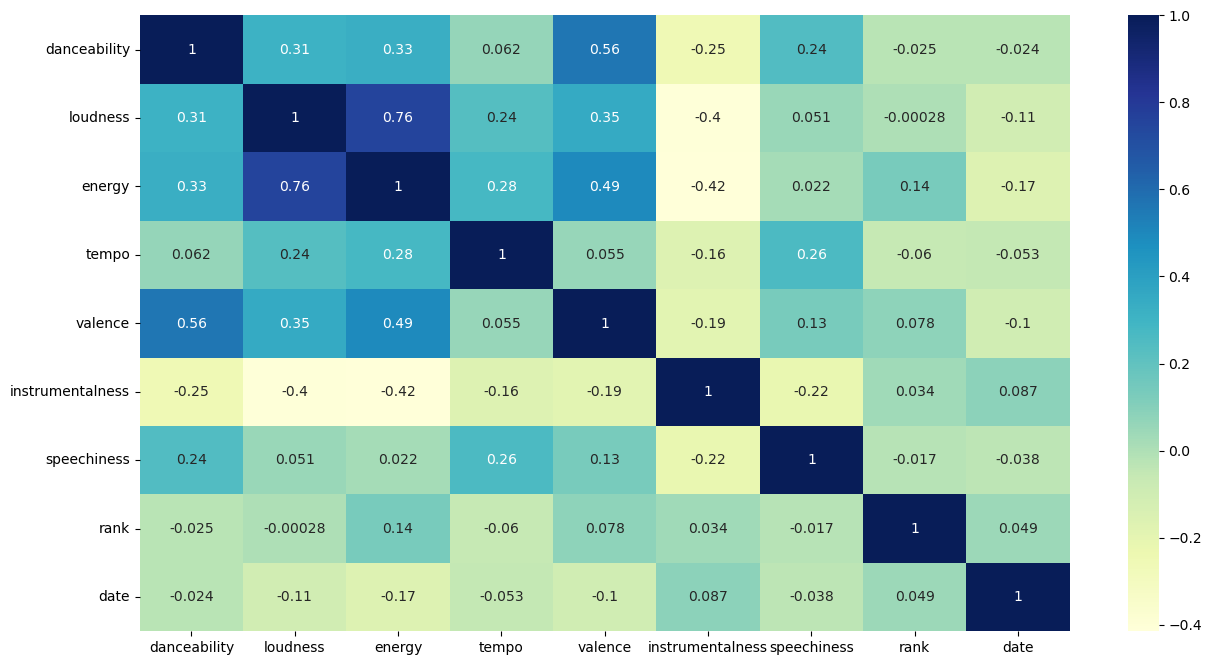

In [403]:
plt.figure(figsize=(15,8))
sb.heatmap(numerical_cols.corr(),annot=True,cmap="YlGnBu")
#plt.savefig("clustermap.png")

In [406]:
song_in_more_than_ten_week = merged_df[merged_df["song"].isin(vc.index[vc > 9])]

In [407]:
song_df

,song,danceability,loudness,energy,tempo,valence,instrumentalness,speechiness,artist,rank,date,charted 8 weeks or more
103,What Was I Made For?,0.8,-6.684,0.535,92.027,0.451,0.000009,0.135,Billie Eilish,24,2023-09-14,1
104,What Was I Made For?,0.8,-6.684,0.535,92.027,0.451,0.000009,0.135,Billie Eilish,17,2023-09-22,1
105,What Was I Made For?,0.8,-6.684,0.535,92.027,0.451,0.000009,0.135,Billie Eilish,6,2023-09-29,0
106,What Was I Made For?,0.8,-6.684,0.535,92.027,0.451,0.000009,0.135,Billie Eilish,6,2023-10-03,0
107,What Was I Made For?,0.8,-6.684,0.535,92.027,0.451,0.000009,0.135,Billie Eilish,10,2023-10-09,1
108,What Was I Made For?,0.8,-6.684,0.535,92.027,0.451,0.000009,0.135,Billie Eilish,12,2023-10-16,1
109,What Was I Made For?,0.8,-6.684,0.535,92.027,0.451,0.000009,0.135,Billie Eilish,16,2023-10-24,1
110,What Was I Made For?,0.8,-6.684,0.535,92.027,0.451,0.000009,0.135,Billie Eilish,28,2023-10-30,1
111,What Was I Made For?,0.8,-6.684,0.535,92.027,0.451,0.000009,0.135,Billie Eilish,29,2023-11-07,1
112,What Was I Made For?,0.8,-6.684,0.535,92.027,0.451,0.000009,0.135,Billie Eilish,25,2023-11-14,1


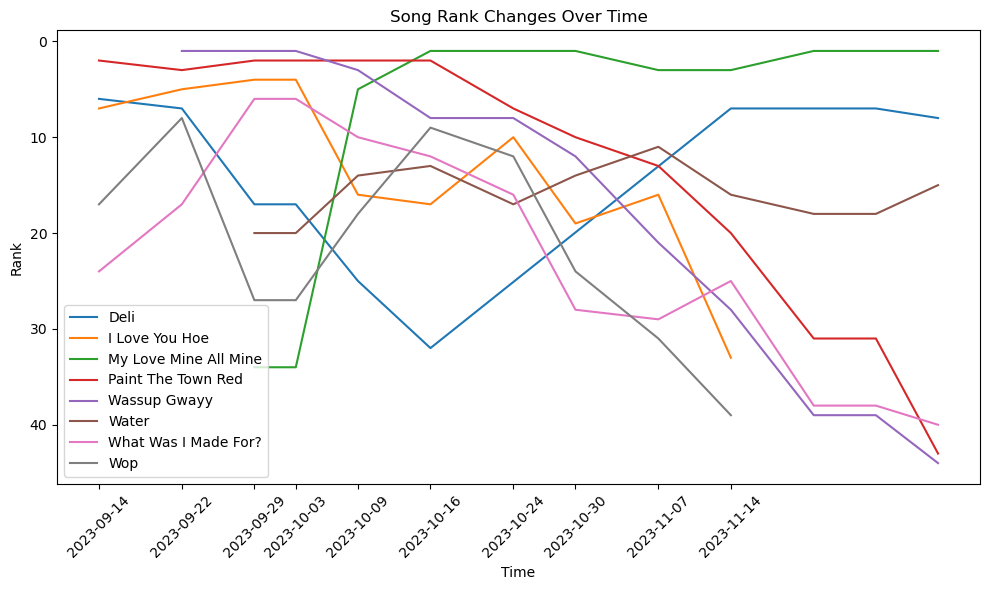

In [408]:
plt.figure(figsize=(10, 6))

for song, song_df in song_in_more_than_ten_week.groupby('song'):
    plt.plot(song_df['date'], song_df['rank'], label=song)

plt.xlabel('Time')
plt.ylabel('Rank')
plt.title('Song Rank Changes Over Time')
plt.legend()
plt.xticks(song_df["date"].unique(),rotation=45)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("ranking time series.png")
plt.show()


array([[<Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'instrumentalness'}>],
       [<Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'rank'}>,
        <Axes: title={'center': 'date'}>]], dtype=object)

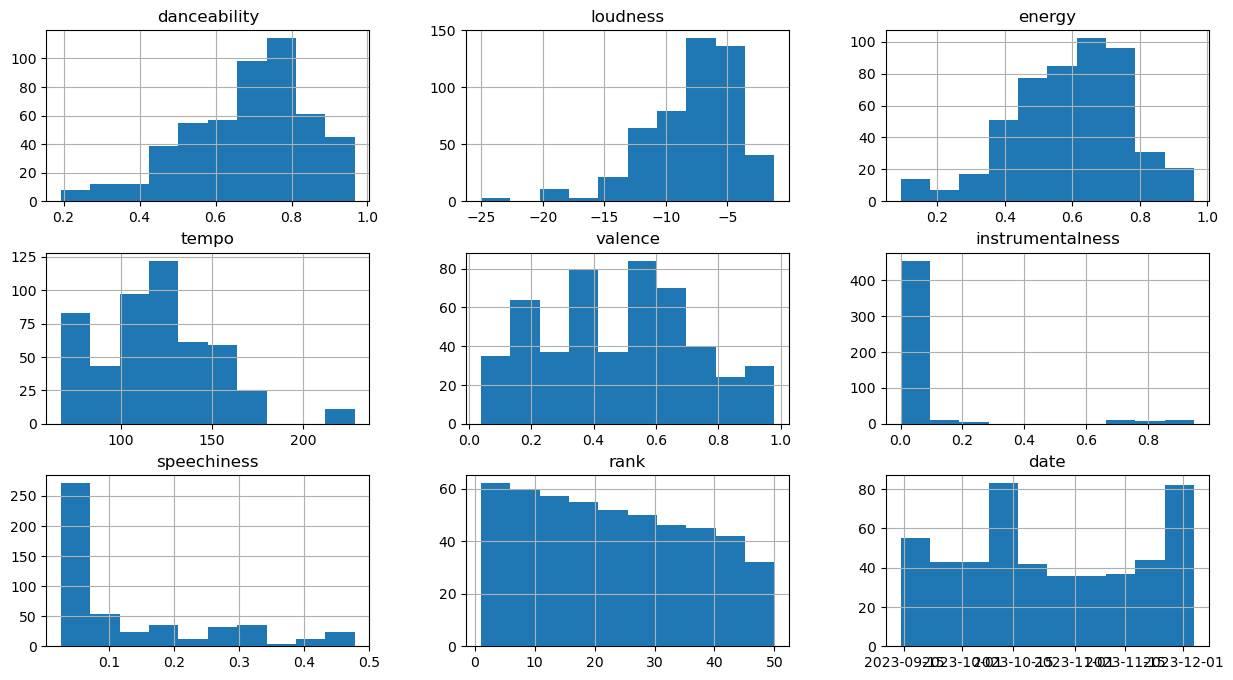

In [161]:
merged_df.hist(figsize=(15,8))

In [457]:
value_counts = merged_df["song"].value_counts()
values_to_mark = value_counts[value_counts >= 6].index.tolist()
merged_df['charts_more_than_6'] = merged_df['song'].apply(lambda x: 1 if x in values_to_mark else 0)


In [458]:
merged_df.head()

,song,danceability,loudness,energy,tempo,valence,instrumentalness,speechiness,artist,rank,date,charts_more_than_6
0,SkeeYee,0.739,-10.843,0.536,82.549,0.6400,0.000000,0.3080,Sexyy Red,1,2023-09-14,1
41,I Love You Hoe,0.789,-6.169,0.763,140.107,0.2720,0.000022,0.1990,Odetari & 9lives,7,2023-09-14,1
51,It's Getting Hot,0.477,-8.300,0.565,151.928,0.0399,0.001100,0.0334,NLE Choppa,8,2023-09-14,0
56,I'm Blessed,0.908,-3.889,0.757,106.031,0.5770,0.000000,0.0606,Charlie Wilson Featuring T.I.,9,2023-09-14,1
124,GMFU,0.193,-18.494,0.171,84.067,0.1050,0.942000,0.0368,Odetari & 6arelyhuman,29,2023-09-14,0


In [459]:
merged_df["charts_more_than_6"].value_counts()

charts_more_than_6
1    289
0    212
Name: count, dtype: int64

In [464]:
unique_songs = merged_df.drop_duplicates(subset="song")

In [466]:
unique_songs

,song,danceability,loudness,energy,tempo,valence,instrumentalness,speechiness,artist,rank,date,charts_more_than_6
0,SkeeYee,0.739,-10.843,0.536,82.549,0.6400,0.000000,0.3080,Sexyy Red,1,2023-09-14,1
41,I Love You Hoe,0.789,-6.169,0.763,140.107,0.2720,0.000022,0.1990,Odetari & 9lives,7,2023-09-14,1
51,It's Getting Hot,0.477,-8.300,0.565,151.928,0.0399,0.001100,0.0334,NLE Choppa,8,2023-09-14,0
56,I'm Blessed,0.908,-3.889,0.757,106.031,0.5770,0.000000,0.0606,Charlie Wilson Featuring T.I.,9,2023-09-14,1
124,GMFU,0.193,-18.494,0.171,84.067,0.1050,0.942000,0.0368,Odetari & 6arelyhuman,29,2023-09-14,0
...,...,...,...,...,...,...,...,...,...,...,...,...
480,Theres This Girl,0.612,-3.078,0.961,129.873,0.8670,0.000042,0.3330,sign crushes motorist,23,2023-11-22,0
489,"Think Of Me Once In A While, Take Care",0.722,-5.451,0.785,122.986,0.5290,0.000000,0.0763,Take Care,29,2023-11-22,0
459,Runaway,0.735,-12.472,0.478,107.682,0.9470,0.000002,0.0293,Kanye West Featuring Pusha T,3,2023-11-22,0
486,500lbs (Slowed Down),0.589,-8.749,0.472,67.196,0.8980,0.000000,0.0502,Lil Tecca,27,2023-11-22,0


In [467]:
unique_songs["charts_more_than_6"].value_counts()

charts_more_than_6
0    58
1    37
Name: count, dtype: int64

In [460]:
import statsmodels.formula.api as smf


In [465]:
log_reg = smf.logit("charts_more_than_6 ~ danceability + loudness + energy + tempo + valence + instrumentalness + speechiness", data=unique_songs).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.637688
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:     charts_more_than_6   No. Observations:                   95
Model:                          Logit   Df Residuals:                       87
Method:                           MLE   Df Model:                            7
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                 0.04611
Time:                        13:58:29   Log-Likelihood:                -60.580
converged:                       True   LL-Null:                       -63.509
Covariance Type:            nonrobust   LLR p-value:                    0.5566
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.0232      2.026     -0.505      0.614      -4.994       2.948
danceabilit

In [373]:
feature_df = merged_df.drop(["song","artist","rank","charted_eight_weeks","tempo","loudness"], axis=1)

In [374]:
average_by_date = feature_df.groupby('date').mean()

In [375]:
dates = merged_df["date"].unique().tolist()

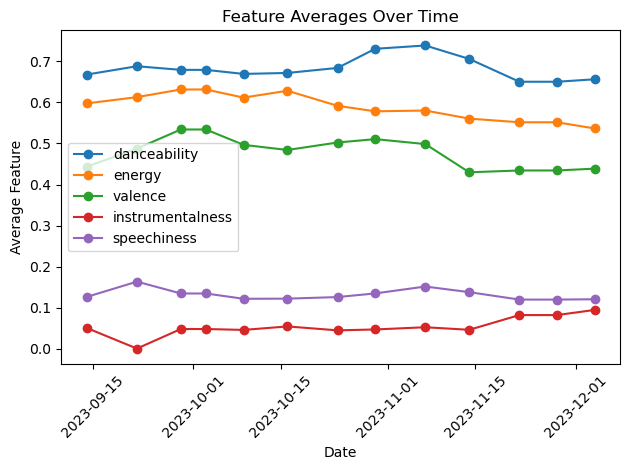

In [409]:
for col in average_by_date.columns:
    plt.plot(dates, average_by_date[col], marker='o', label=col)
plt.xlabel('Date')
plt.ylabel('Average Feature')
plt.title('Feature Averages Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("features over time.png")
plt.show()

In [377]:
loudness = merged_df[["loudness","date"]]

In [378]:
average_by_date_loudness = loudness.groupby('date').mean()

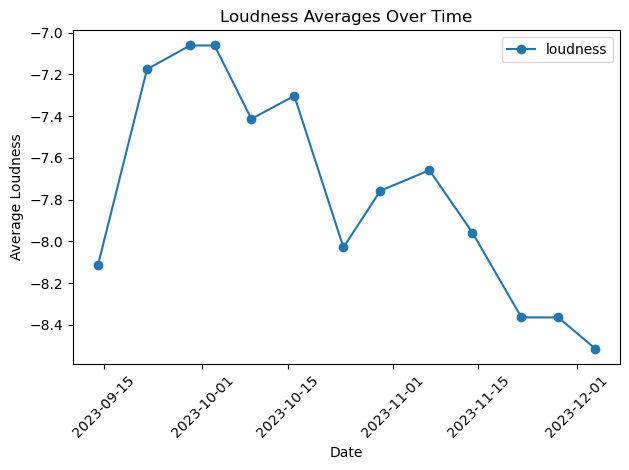

In [380]:
plt.plot(dates, average_by_date_loudness["loudness"], marker='o', label="loudness")
plt.xlabel('Date')
plt.ylabel('Average Loudness')
plt.title('Loudness Averages Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [365]:
tempo = merged_df[["tempo","date"]]

In [366]:
average_by_date_tempo = tempo.groupby("date").mean()

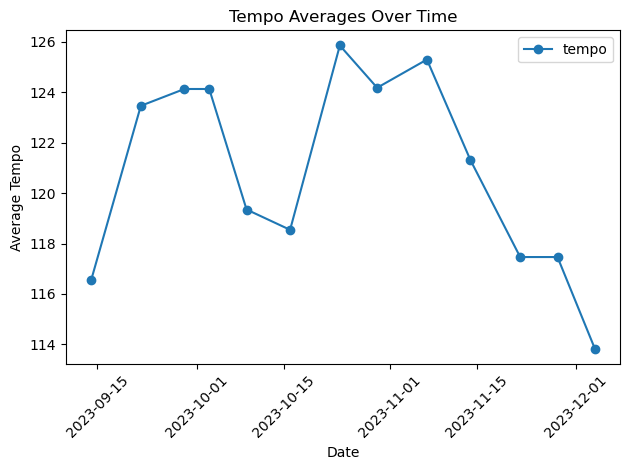

In [382]:
plt.plot(dates, average_by_date_tempo["tempo"], marker='o', label="tempo")
plt.xlabel('Date')
plt.ylabel('Average Tempo')
plt.title('Tempo Averages Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [388]:
rank_1 = merged_df[merged_df["rank"] == 1]

In [389]:
feature_top_song_df = rank_1.drop(["song","artist","rank","charted_eight_weeks","tempo","loudness"], axis=1)

In [390]:
rank_one_features = feature_top_song_df.groupby('date').mean()

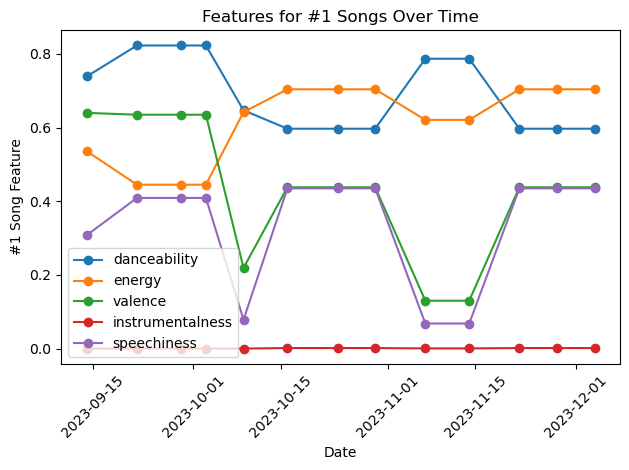

In [397]:
for col in rank_one_features.columns:
    plt.plot(dates, rank_one_features[col], marker='o', label=col)
plt.xlabel('Date')
plt.ylabel('#1 Song Feature')
plt.title('Features for #1 Songs Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [398]:
loudness_rank_1 = rank_1[["loudness","date"]]

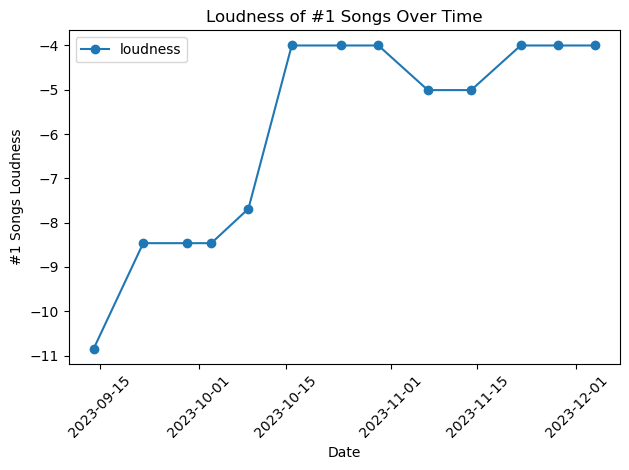

In [400]:
plt.plot(dates, loudness_rank_1["loudness"], marker='o', label="loudness")
plt.xlabel('Date')
plt.ylabel('#1 Songs Loudness')
plt.title('Loudness of #1 Songs Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

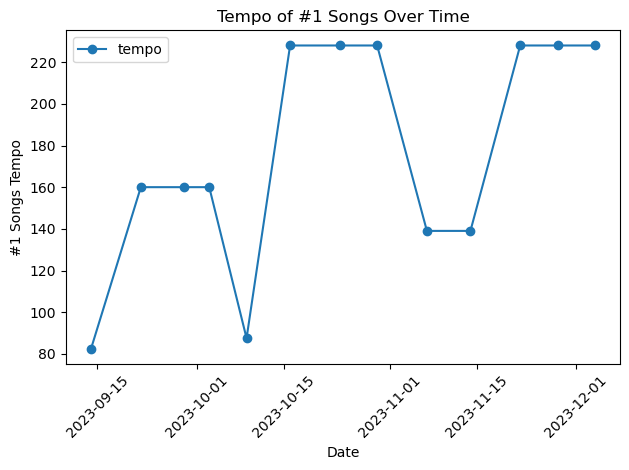

In [401]:
tempo_rank_1 = rank_1[["tempo","date"]]
plt.plot(dates, tempo_rank_1["tempo"], marker='o', label="tempo")
plt.xlabel('Date')
plt.ylabel('#1 Songs Tempo')
plt.title('Tempo of #1 Songs Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [473]:
merged_df.loc[merged_df["song"] == "Paint The Town Red"]

,song,danceability,loudness,energy,tempo,valence,instrumentalness,speechiness,artist,rank,date,charts_more_than_6
9,Paint The Town Red,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Doja Cat,2,2023-09-14,1
10,Paint The Town Red,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Doja Cat,3,2023-09-22,1
11,Paint The Town Red,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Doja Cat,2,2023-09-29,1
12,Paint The Town Red,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Doja Cat,2,2023-10-03,1
13,Paint The Town Red,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Doja Cat,2,2023-10-09,1
14,Paint The Town Red,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Doja Cat,2,2023-10-16,1
15,Paint The Town Red,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Doja Cat,7,2023-10-24,1
16,Paint The Town Red,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Doja Cat,10,2023-10-30,1
17,Paint The Town Red,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Doja Cat,13,2023-11-07,1
18,Paint The Town Red,0.739,-10.843,0.536,82.549,0.64,0.0,0.308,Doja Cat,20,2023-11-14,1
